In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [8]:
global_psf1 = [1.6,1.6]   # old parameters
global_psf2 = [1.8,2.2]

global_psf1 = [1.8,2.0]   # new parameters
global_psf2 = [1.8,2.0]

Don't need to run just the PSF measurement stuff so skip these cells...

In [12]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a**2.
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

## Re-run A&L vs. ZOGY shootout with measured PSFs.

See (29.1. and 29.2. notebooks to see why I chose 750 as varSourceFlux. Basically, because that is right around 5 sigma.

In [9]:
def runTest(n_sources=500, seed=66, n_varSources=50, varSourceFlux=750., scintillation=0., sky=300., 
            constantDiffimStellarDensity=True, printErrs=False):
    out = None
    try:
        # Make the "varying density" object to fit PSFs on
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                             offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(varSourceFlux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(400,100000), scintillation=scintillation,
                             seed=seed, psfSize=21, avoidBorder=True)

        testObj2 = testObj
        if constantDiffimStellarDensity:
        # Make the "constant density" object to actually run the tests on
            testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                                 offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                                 #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                                 varFlux2=np.repeat(varSourceFlux, n_varSources), variablesNearCenter=False,
                                 theta1=0., theta2=-45., im2background=0., n_sources=1000, 
                                 sourceFluxRange=(400,100000), scintillation=scintillation,
                                 seed=seed, psfSize=21, avoidBorder=True)
            
        savedAstrVariance = list(testObj.astrometricOffsets)
        inputAstrScintillation = scintillation

        if scintillation == 0:
            testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
            testObj2.astrometricOffsets[0] = testObj2.astrometricOffsets[1] = 0.

        try:
            testRes1 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE1', e
            testRes1 = None
        
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = dit.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = dit.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.computeMoments(psf1)
        except Exception as e:
            if printErrs:
                print 'HERE2', e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = dit.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = dit.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.computeMoments(psf2)
        except Exception as e:
            if printErrs:
                print 'HERE3', e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        try:
            testObj2.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj2.im1.psf = psf1b
            testObj2.im2.psf = psf2b
            testRes2 = testObj2.runTest(zogyImageSpace=False)
        except Exception as e:
            if printErrs:
                print 'HERE4', e
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2,
               'measuredAstrVariance': savedAstrVariance,
               'inputAstrScintillation': inputAstrScintillation}
    except Exception as e:
        if printErrs:
            print 'HERE5', e
        pass
    return out

In [13]:
tmp = runTest(n_sources=500, seed=1, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 39, 'FP': 3, 'TP': 11},
  'ALstack_noDecorr': {'FN': 36, 'FP': 3, 'TP': 14},
  'SZOGY': {'FN': 41, 'FP': 5, 'TP': 9},
  'ZOGY': {'FN': 36, 'FP': 0, 'TP': 14}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 39, 'FP': 5, 'TP': 11},
  'ALstack_noDecorr': {'FN': 36, 'FP': 3, 'TP': 14},
  'SZOGY': {'FN': 40, 'FP': 3, 'TP': 10},
  'ZOGY': {'FN': 37, 'FP': 3, 'TP': 13}},
 'inputAstrScintillation': 0.0,
 'inputShape1': [1.897353265540688,
  3.9999527936784536,
  3.2399471828010977,
  -0.0],
 'inputShape2': [1.8973504460825783,
  3.6199385132211397,
  3.6199385132211397,
  -0.3799948498961387],
 'measuredAstrVariance': [0.0028357445896209275, 0.0023189909586263358],
 'moments1': (20.175825087527283, 19.435676020025824),
 'moments2': (20.146183488133364, 20.091219278055306),
 'nSources': 500,
 'normedRms1': 0.0098350931660215295,
 'normedRms2': 0.010637244407452858,
 'rms1': 0.00046621800942291098,
 'rms2': 0.0003528097159770295,
 'seed': 1,
 'shape1': [1.8

In [14]:
tmp = runTest(n_sources=4500, seed=2, printErrs=True);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 37, 'FP': 7, 'TP': 13},
  'ALstack_noDecorr': {'FN': 37, 'FP': 8, 'TP': 13},
  'SZOGY': {'FN': 39, 'FP': 4, 'TP': 11},
  'ZOGY': {'FN': 37, 'FP': 3, 'TP': 13}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 38, 'FP': 7, 'TP': 12},
  'ALstack_noDecorr': {'FN': 37, 'FP': 8, 'TP': 13},
  'SZOGY': {'FN': 38, 'FP': 4, 'TP': 12},
  'ZOGY': {'FN': 39, 'FP': 4, 'TP': 11}},
 'inputAstrScintillation': 0.0,
 'inputShape1': [1.897353265540688,
  3.9999527936784536,
  3.2399471828010977,
  -0.0],
 'inputShape2': [1.8973504460825783,
  3.6199385132211397,
  3.6199385132211397,
  -0.3799948498961387],
 'measuredAstrVariance': [0.00016302612865467015, 0.00014978932989971434],
 'moments1': (19.791934121561805, 20.360419433669694),
 'moments2': (19.842573915019255, 20.361935253860672),
 'nSources': 4500,
 'normedRms1': 0.0056188839895142915,
 'normedRms2': 0.0067850655928523781,
 'rms1': 0.00015320379689934784,
 'rms2': 0.00015858318209655331,
 'seed': 2,
 'shape1'

In [15]:
inputs = [(i, j) for i in np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000]) for j in np.arange(1, 25)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)
import cPickle; import gzip
#cPickle.dump((testResults1, testResults2), gzip.GzipFile('29. 3. psf measurement evaluation.p.gz', 'wb'))

600


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 13.2min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 41.9min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 92.1min finished


600 529


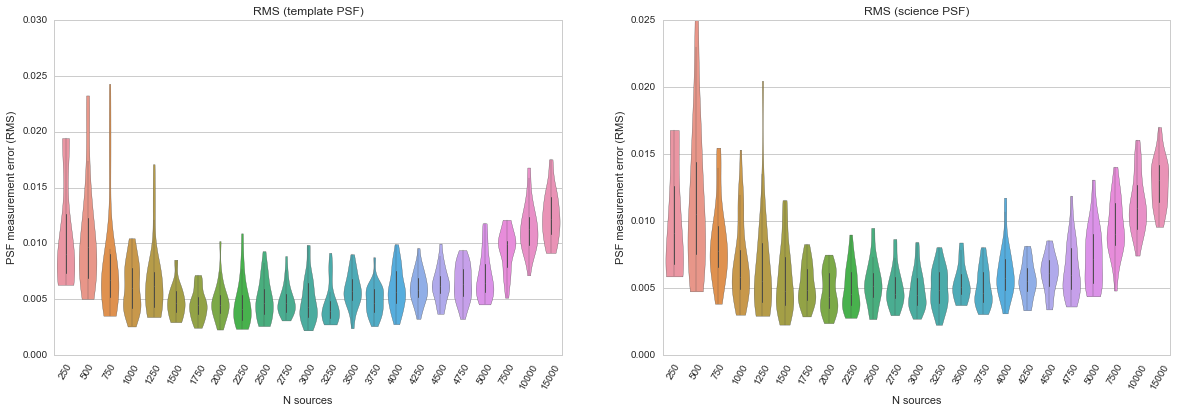

In [16]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults2[i] is not None])
tr = [t for t in testResults2 if t is not None and t['inputPsf1'] is not None and t['psf1'] is not None]
tr = [t for t in tr if t is not None and t['inputPsf2'] is not None and t['psf2'] is not None]
#tr = [t for t in tr if t is not None and t['psf1'] is not None]
#tr = [t for t in tr if t['rms1'] is not None]
#tr = [t for t in tr if t['rms2'] is not None]
print len(testResults2), len(tr)
ns = np.array([t['nSources'] for t in tr if t is not None])
rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in tr if t is not None]
rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in tr if t is not None]

tr = {'nSources': ns,
      #'rms1': np.array([t['rms1'] for t in tr])*100.,
      #'rms2': np.array([t['rms2'] for t in tr])*100.,
      #'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      #'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])
     }
tr = pd.DataFrame(tr)

tr['rms1'] = np.array(rms1s)
tr['rms2'] = np.array(rms2s)

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0],
                  scale='width')
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_ylim(0, 0.030)
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1],
                  scale='width')
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_ylim(0, 0.025)
g.set_xticklabels(g.get_xticklabels(), rotation=60);

In [17]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    tr = [t for t in tr if t is not None]
    tr = [t for t in tr if t is not None and t['diffimResMeasuredPsf']]
    TP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FP'] for t in tr]) for key in methods})

    TP['nSources'] = np.array([t['nSources'] for t in tr])
    FP['nSources'] = np.array([t['nSources'] for t in tr])
    FN['nSources'] = np.array([t['nSources'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['nSources', methods[0]]]
    tmp2 = TP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0], scale='width')
    g.set_title('True Positives')
    g.set_ylim((0, 25))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['nSources', methods[0]]]
    tmp2 = FP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], scale='width')
    g.set_title('False Positives')
    g.set_ylim((0, 25))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

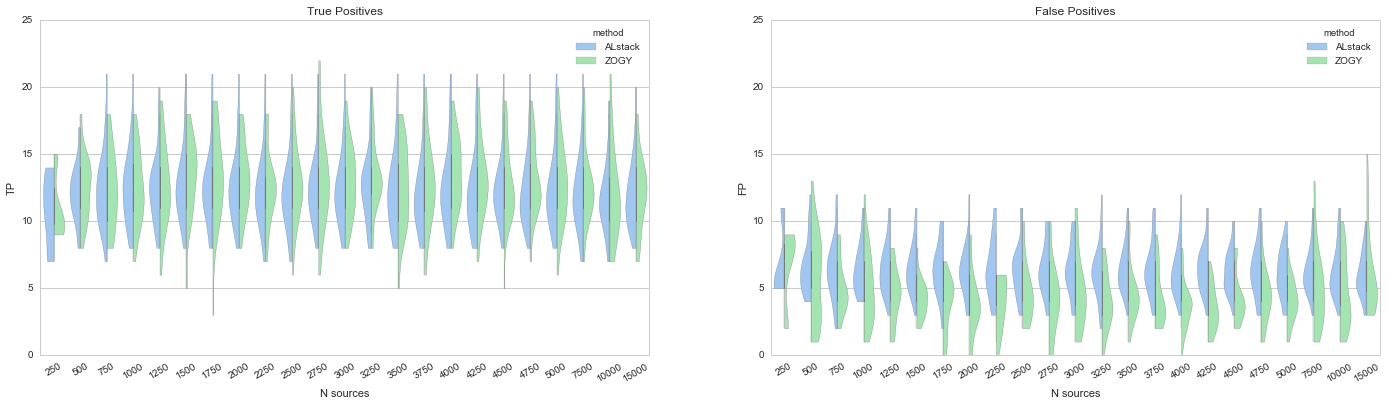

In [18]:
plotResults(testResults2, methods=['ALstack', 'ZOGY'])

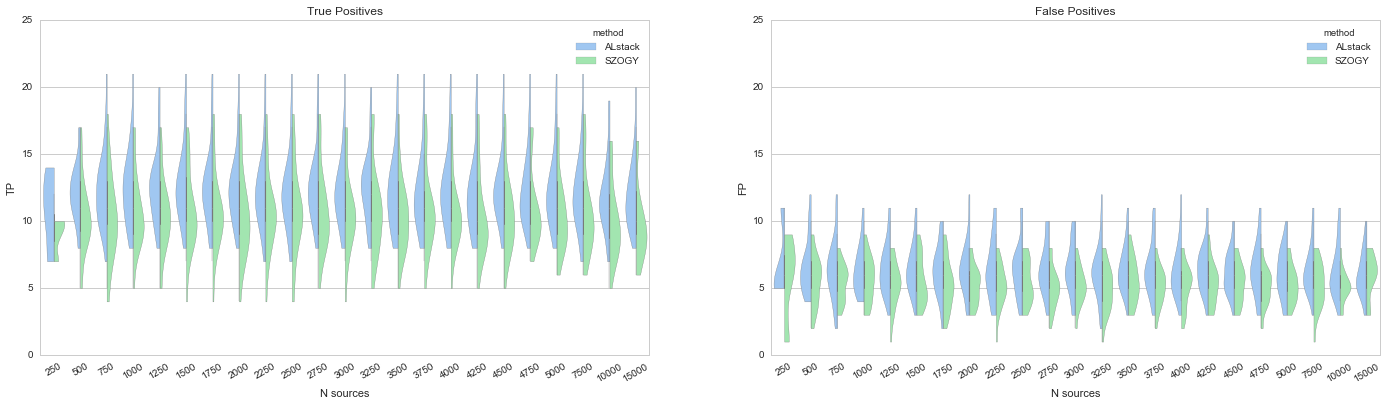

In [19]:
plotResults(testResults2, methods=['ALstack', 'SZOGY'])

In [21]:
cPickle.dump((testResults2), gzip.GzipFile('29. 4. psf measurement evaluation.p.gz', 'wb'))

## Let's just see what the really dense fields look like.

{'ZOGY': {'FP': 3, 'FN': 38, 'TP': 12}, 'ALstack': {'FP': 2, 'FN': 39, 'TP': 11}, 'SZOGY': {'FP': 5, 'FN': 43, 'TP': 7}, 'ALstack_noDecorr': {'FP': 2, 'FN': 36, 'TP': 14}}


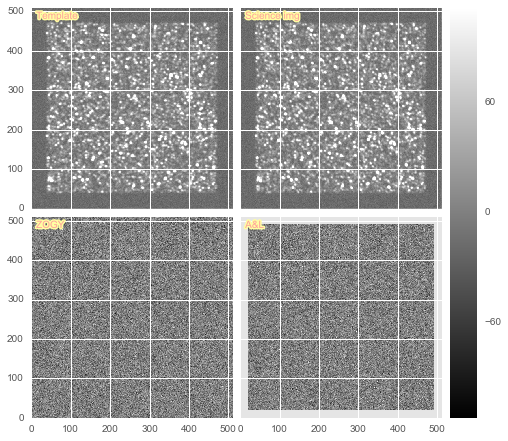

In [22]:
reload(dit)
testObj = dit.DiffimTest(imSize=(512,512), sky=300., psf1=global_psf1, psf2=global_psf2,
                         offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                         varFlux2=np.repeat(750., 50), variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=15000, 
                         sourceFluxRange=(400,100000), avoidBorder=True, 
                         seed=1, psfSize=21)

res = testObj.runTest()
print res

fig = plt.figure(1, (8, 8))
testObj.doPlot()

In [23]:
inputs = [(i, j) for i in np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000]) for j in np.arange(1, 25)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1], \
                                                                      constantDiffimStellarDensity=False) for i in inputs)

600


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 11.0min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 37.1min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 83.0min finished


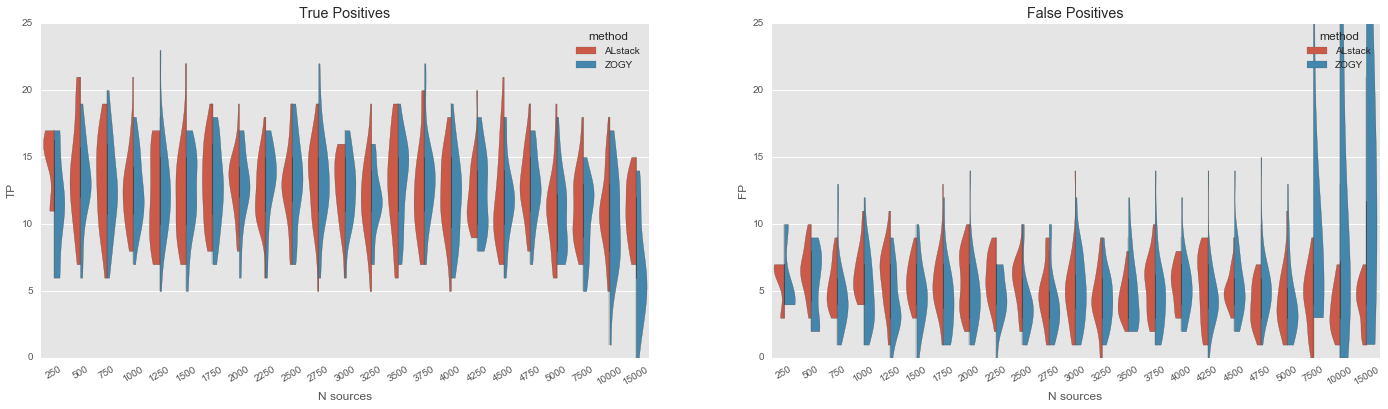

In [24]:
plotResults(testResults3, methods=['ALstack', 'ZOGY'])

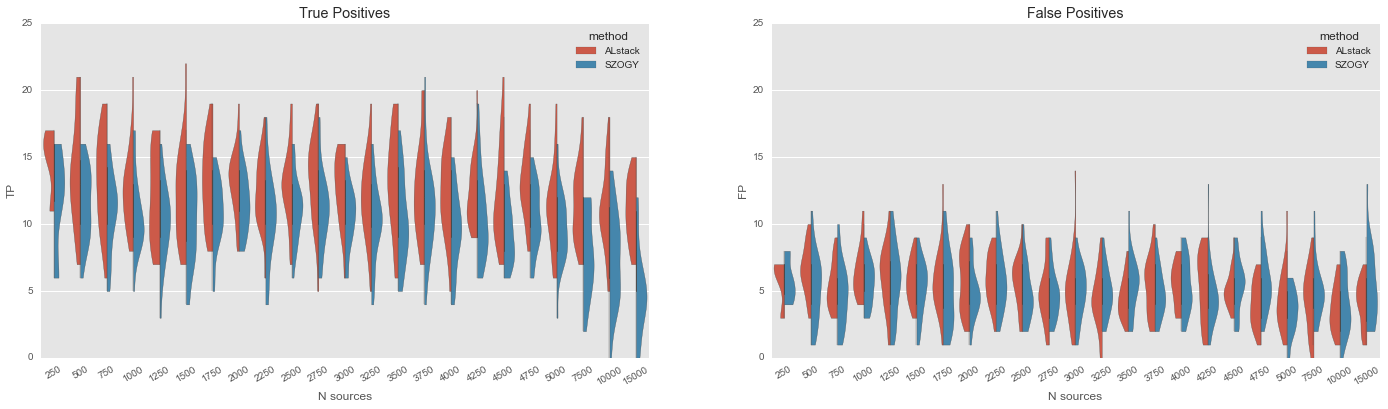

In [25]:
plotResults(testResults3, methods=['ALstack', 'SZOGY'])

In [26]:
cPickle.dump((testResults2, testResults3), gzip.GzipFile('29. 4. psf measurement evaluation.p.gz', 'wb'))

### Now run the simulations with "scintillation"...

In [27]:
inputs = [(i, j) for i in np.append(np.insert(np.arange(500, 5001, 250), 0, [50, 100, 250]), [7500, 10000, 15000]) for j in np.arange(1, 25)]
print len(inputs)
testResults4 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1], scintillation=0.05, \
                                                                      constantDiffimStellarDensity=False) for i in inputs)

600


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 39.6min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 88.1min finished


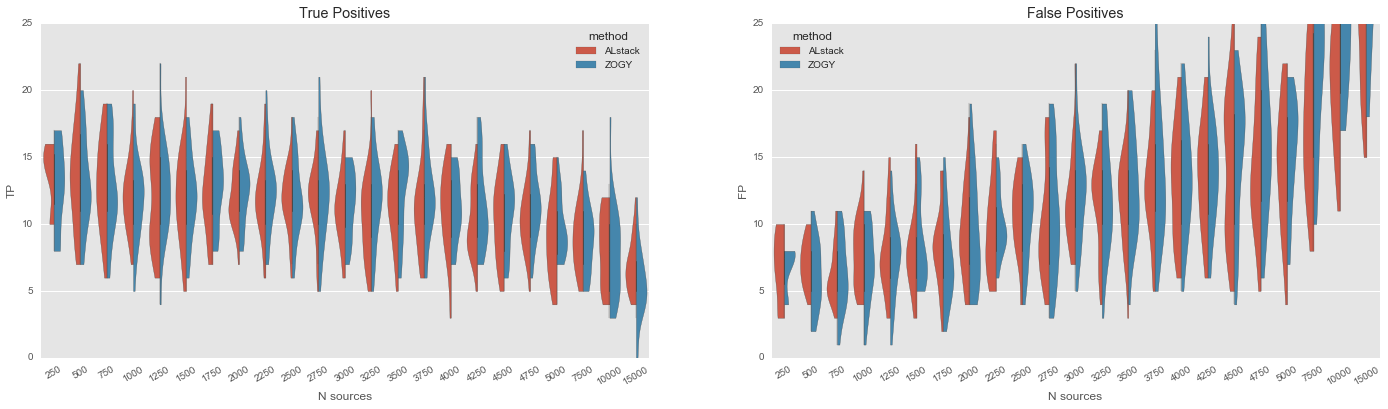

In [28]:
plotResults(testResults4, methods=['ALstack', 'ZOGY'])

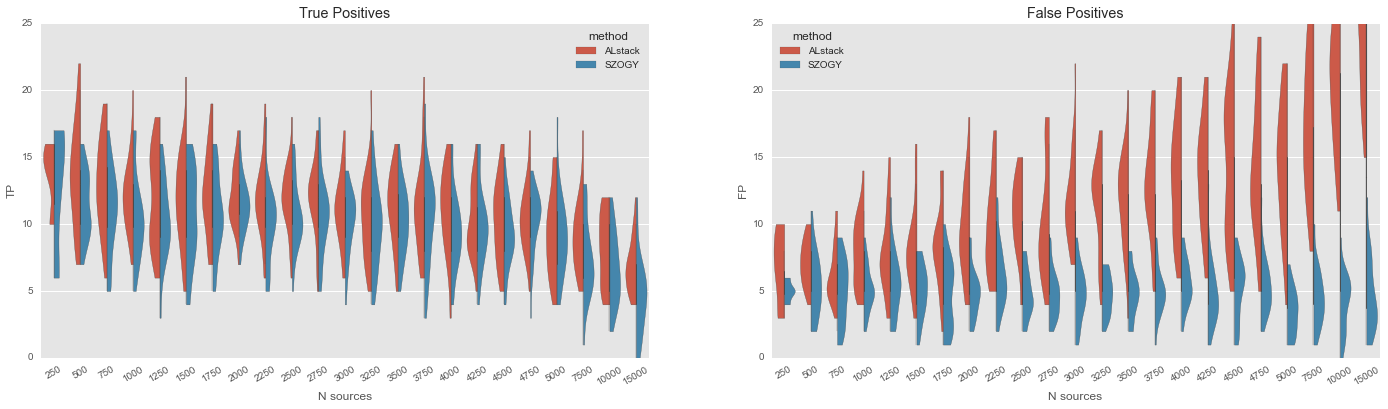

In [29]:
plotResults(testResults4, methods=['ALstack', 'SZOGY'])

In [30]:
cPickle.dump((testResults2, testResults3, testResults4), 
             gzip.GzipFile('29. 4. psf measurement evaluation.p.gz', 'wb'))